In [1]:
from IPython.display import display, Image
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division

import os
import math
import idx2numpy
import scipy.misc
import numpy as np
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt

In [3]:
# data_dir = '/Volumes/700_GB/Study/SVHN/P5_Digit_Recognition/'
data_dir = ''
mnist_dataset_location = data_dir + 'datasets/MNIST/'

In [4]:
# Get Random Probablistic distribution
# for number of digits to keep in manufactured data
# numbers and their probablities are written
#
# @param : required_numbers
#          how many numbers do ypu require
def get_rand_dist(required_numbers):
    elements =     [1,    2,    3,    4,    5,    6,    7,    8,    9,    10  ]
    probabilites = [0.10, 0.10, 0.15, 0.25, 0.15, 0.06, 0.07, 0.06, 0.03, 0.03]

    return(np.random.choice(elements, required_numbers, p=probabilites))

<Container object of 10 artists>

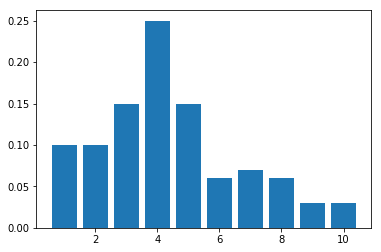

In [5]:
elements =     [1,    2,    3,    4,    5,    6,    7,    8,    9,    10  ]
probabilites = [0.10, 0.10, 0.15, 0.25, 0.15, 0.06, 0.07, 0.06, 0.03, 0.03]
plt.bar(elements, probabilites)

In [6]:
# Possible ways data could look
# 1. (50%)
#   - - - - - - - -
#
# 2. (15%)
#   - - - - -
#    - - - -
#
# 3. (15%)
#   -
#     -
#       -
#         -
#
# 4. (10%)
#         -
#       -
#     -
#   -
#
def get_rand_style():
    elements =     [1,    2,    3,    4   ]
    probabilites = [0.60, 0.15, 0.15, 0.10]

    return(np.random.choice(elements, 1, p=probabilites)[0])

In [8]:
MAX_DIGITS = 10
label_width = MAX_DIGITS + 1

In [9]:
OUT_SHAPE = (64, 64)

In [10]:
# Pad images with randomly chosen padding from [4,6,8,10,12,14]
# Image will be padded with additional 0
# Return padded image as well as padding
def add_random_padding(np_image_list):
    possible_paddings = [4,8,12,16,20,24,28]
    padding = np.random.choice(possible_paddings)
    
    padded_images = []
    for image in np_image_list:
        padded_images.append(np.pad(image, padding, 'constant', constant_values=(0,0)))
    return(padding ,padded_images)

In [12]:
# Label 10 will mean empty space or no number
def place_images(images_list, padding, label_list, img_style, original_size):
    num_images = len(images_list)
    bbox_list = list()
    
    new_image = np.zeros((32, 32))
    new_label = np.empty((MAX_DIGITS+1), dtype='int')
    new_label[0] = num_images
    for i in range(num_images+1, label_width):
        new_label[i] = 10
    
    white_image = np.zeros(images_list[0].shape)
    p = padding
    l = original_size[0]
    
    if num_images == 1:
            new_image = images_list[0]
            new_label[1] = label_list[0]
    
            bbox_list.append([(padding, padding), (padding + original_size[0], padding + original_size[1])])
            
    else :
        if img_style == 1:
            # Style : - - - - - -
            new_image = np.hstack(images_list)
            
            # assuming square image for bounding boxes
            for i in range(num_images):
                k = i + 1
                new_label[k] = label_list[i]
                bbox_list.append([((k-1)*l+(2*k-1)*p, p), ( k*l+(2*k-1)*p, l+p)])
            

        elif img_style == 2:
            # Style : - - - -
            #          - - -
            images_above = int(math.ceil(num_images/2))
            images_below = num_images - images_above
            
            if images_above == images_below:
                im_1 = np.hstack(images_list[:images_above])
                im_2 = np.hstack(images_list[images_above:])
                        
            else:        
                im_1 = np.hstack(images_list[:images_above])
                new_list = images_list[images_above:]
                new_list.append(white_image)
                im_2 = np.hstack(new_list)
            
            new_image = np.vstack([im_1, im_2])
            
             # assuming square image for bounding boxes
            for i in range(images_above):
                k = i + 1
                bbox_list.append([((k-1)*l+(2*k-1)*p, p), (k*l+(2*k-1)*p, l+p)])

            # assuming square image for bounding boxes
            for i in range(images_below):
                k = i + 1
                bbox_list.append([((k-1)*l+(2*k-1)*p, l+3*p), ( k*l+(2*k-1)*p, 2*l+3*p)])
                
            for i in range(num_images):
                k = i + 1
                new_label[k] = label_list[i]
                
            
        elif img_style == 3:
            # Style : inclining staircase
            white_image = np.zeros(images_list[0].shape)
            
            v_stack_list = []
            for k in range(num_images):
                h_stack_list = [white_image] * num_images
                index = num_images - (k + 1)
                h_stack_list[index] = images_list[-k-1]
                h_stack = np.hstack(h_stack_list)
                v_stack_list.append(h_stack)
            
            new_image = np.vstack(v_stack_list)
            
            # assuming square image for bounding boxes
            for i in range(num_images):
                k = i + 1
                new_label[k] = label_list[i]
                a, b = ((k    *l+(2*k-1)*p, num_images*(l+2*p) - (k    *l+(2*k-1)*p)))
                c, d = (((k-1)*l+(2*k-1)*p, num_images*(l+2*p) - ((k-1)*l+(2*k-1)*p)))
                bbox_list.append([(a, b), (c, d)])
            
        else:
            # Style : declining staircase
            white_image = np.zeros(images_list[0].shape)
            
            v_stack_list = []
            for k in range(num_images):
                h_stack_list = [white_image] * num_images
                h_stack_list[k] = images_list[k]
                h_stack = np.hstack(h_stack_list)
                v_stack_list.append(h_stack)
            
            new_image = np.vstack(v_stack_list)
            
            # assuming square image for bounding boxes
            for i in range(num_images):
                k = i + 1
                new_label[k] = label_list[i]
                a, b = (( k   *l+(2*k-1)*p,  k   *l+(2*k-1)*p))
                c, d = (((k-1)*l+(2*k-1)*p, (k-1)*l+(2*k-1)*p))
                bbox_list.append([(a, b), (c, d)])
            
    return(new_image, bbox_list, new_label)

In [14]:
def get_new_bbox(bbox, old_shape, new_shape):
    Ry = (new_shape[0] * 1.00)/old_shape[0]
    Rx = (new_shape[1] * 1.00)/old_shape[1]
    
    new_box = []
    for box in bbox:
        x1, y1 = (int(Rx * box[0][0]), int(Ry * box[0][1]))
        x2, y2 = (int(Rx * box[1][0]), int(Ry * box[1][1]))
        new_box.append([(x1, y1), (x2, y2)])
        
    return(new_box)

In [15]:
def transform_box_to_np(bbox):
    new_box = np.empty((4*MAX_DIGITS), dtype='int')
    for i in range(len(bbox)):
        new_box[4*i  ] = bbox[i][0][0]
        new_box[4*i+1] = bbox[i][0][1]
        new_box[4*i+2] = bbox[i][1][0]
        new_box[4*i+3] = bbox[i][1][1]
        
    # Assining empty spaces bbox (0,0), (5,5)
    for i in range(len(bbox), MAX_DIGITS):
        new_box[4*i  ] = 0
        new_box[4*i+1] = 0
        new_box[4*i+2] = 5
        new_box[4*i+3] = 5
        
    return new_box

In [16]:
def pipeline_secondary(np_images, np_labels, rand_index_list, output_shape):
    input_shape = np_images[0].shape
    images_list, labels_list = [], []

    for rand in rand_index_list:
        images_list.append(np_images[rand])
        labels_list.append(np_labels[rand])
    
    style = get_rand_style()
    padding, padded_img_list = add_random_padding(images_list)
    new_img, bbox, new_label = place_images(padded_img_list, padding, labels_list, style, input_shape)
    
    new_img_resized = scipy.misc.imresize(new_img, output_shape)
    box_new = get_new_bbox(bbox, new_img.shape, new_img_resized.shape)
    box_np = transform_box_to_np(box_new)
    
    return(new_img_resized, box_np, new_label)

In [17]:
def pipeline_primary(np_images, np_labels, target_output, output_shape):
    number_of_samples = np_images.shape[0]
    rand_dist = get_rand_dist(target_output)
    rand_index_list = list()
    for rand in rand_dist:
        rand_index_list.append(np.random.randint(0, number_of_samples, rand))
    
    out_images = np.zeros((target_output, output_shape[0], output_shape[1]))
    out_labels = np.zeros((target_output, 11))
    out_box    = np.zeros((target_output, 4*MAX_DIGITS))
    
    for i in range(target_output):
        new_img_resized, box_np, new_label = pipeline_secondary(np_images, np_labels, rand_index_list[i], output_shape)
        out_images[i] = new_img_resized
        out_labels[i] = new_label
        out_box[i] = box_np
        
    return(out_images, out_labels, out_box)

In [26]:
def draw_rectangles(image, bbox_list):
    img = Image.fromarray(image)
    draw = ImageDraw.Draw(img)
    blank_box = [0, 0, 5, 5]
    
    for i in range(MAX_DIGITS):
        bbox = list()
        bbox.append(bbox_list[4*i+0])
        bbox.append(bbox_list[4*i+1])
        bbox.append(bbox_list[4*i+2])
        bbox.append(bbox_list[4*i+3])

        # Do not draw bounding box for blank image
        if bbox != blank_box:
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            draw.rectangle(((x1, y1), (x2, y2)), fill=None, outline=(255))  
        
    return(np.asarray(img))

In [48]:
def draw_bbox_images(np_images, np_labels, np_box):
    fig, ax = plt.subplots(nrows=int(np_images.shape[0]/2),ncols=2,figsize=(15,64))
    
    for i in range(np_images.shape[0]):
        image = np_images[i]
        bbox_list = np_box[i]
        label = np_labels[i]

        box_img = draw_rectangles(image, bbox_list)
        
        plt.subplot(np_images.shape[0]/2,2,i+1)
        plt.title(label)
        plt.imshow(box_img)
    plt.show()

In [50]:
test_images = idx2numpy.convert_from_file(mnist_dataset_location + 't10k-images-idx3-ubyte')
test_label = idx2numpy.convert_from_file(mnist_dataset_location + 't10k-labels-idx1-ubyte')

train_images = idx2numpy.convert_from_file(mnist_dataset_location + 'train-images-idx3-ubyte')
train_label = idx2numpy.convert_from_file(mnist_dataset_location + 'train-labels-idx1-ubyte')

In [51]:
test_out_images, test_out_labels, test_out_box = pipeline_primary(test_images, test_label, 25000, OUT_SHAPE)
train_out_images, train_out_labels, train_out_box = pipeline_primary(test_images, test_label, 125000, OUT_SHAPE)

In [52]:
np.save(mnist_dataset_location + 'train_images', train_out_images)
np.save(mnist_dataset_location + 'train_labels', train_out_labels)
np.save(mnist_dataset_location + 'train_bboxes', train_out_box)

np.save(mnist_dataset_location + 'test_images', test_out_images)
np.save(mnist_dataset_location + 'test_labels', test_out_labels)
np.save(mnist_dataset_location + 'test_bboxes', test_out_box)